### IMPORT PACKAGE

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095450 sha256=6cbbdff3676beba78ad8b5df983382ac90526544feca55b835f97a6ed3cd7cf2
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Similarity
from surprise import Dataset, Reader, accuracy, SVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

### DATA PREP

In [ ]:
# Read in data
ratings=pd.read_csv('/content/rate_colla.csv', sep=';')

# Take a look at the data
ratings.head()

rating_id  user_id  pack_id  rating
0          1        1        1       4
1          2        1        2       3
2          3        1        3       5
3          4        1        4       2
4          5        1        5       4

In [ ]:
# Read in data
pack = pd.read_csv('/content/package_tour.csv', sep=';')


# Remove unnecessary columns
pack = pack.drop(['duration', ' budget ', 'pack_bundle', 'Unnamed: 5'], axis=1)


# Take a look at the data
# pack.drop(columns='Unnamed: 5', inplace=True)
# pack.drop(columns='duration', inplace=True)
# # pack.drop(columns='budget', inplace=True)
# pack.drop(columns='pack_bundle', inplace=True)
pack.head()

pack_id         package_name
0        1      Combo Program 1
1        2      Combo Program 2
2        3      Combo Program 3
3        4  Overnight Package 1
4        5  Overnight Package 2

In [ ]:
pack.columns

Index(['pack_id', 'package_name'], dtype='object')

In [ ]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   rating_id  120 non-null    int64
 1   user_id    120 non-null    int64
 2   pack_id    120 non-null    int64
 3   rating     120 non-null    int64
dtypes: int64(4)
memory usage: 3.9 KB


In [ ]:
# Get the dataset information
pack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pack_id       5 non-null      int64 
 1   package_name  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


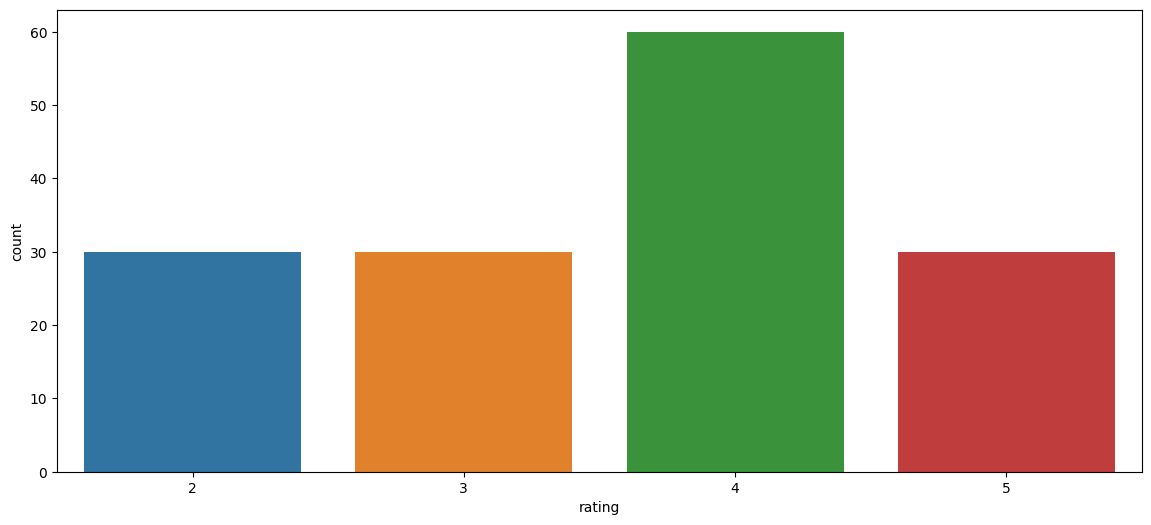

In [ ]:
# Visualizing with the act_rating column
act_ratings=ratings['rating'].value_counts()

dims = (14, 6)
fig, ax = plt.subplots(figsize=dims)
ax = sns.countplot(x=ratings.rating)

In [ ]:
# Number of users
print('The ratings dataset has', ratings['user_id'].nunique(), 'unique users')

# Number of package
print('The ratings dataset has', ratings['pack_id'].nunique(), 'unique package')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 30 unique users
The ratings dataset has 5 unique package
The ratings dataset has 4 unique ratings
The unique ratings are [2, 3, 4, 5]


In [ ]:
# Merge ratings and package datasets
df = pd.merge(ratings, pack, on='pack_id', how='inner')

# Take a look at the df
df.head()


rating_id  user_id  pack_id  rating     package_name
0          1        1        1       4  Combo Program 1
1          6        2        1       4  Combo Program 1
2         11        3        1       4  Combo Program 1
3         16        4        1       4  Combo Program 1
4         21        5        1       4  Combo Program 1

In [ ]:
# Load data from DataFrame
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'pack_id', 'rating']], reader)


In [ ]:
average_ratings = pd.DataFrame(data.raw_ratings, columns=['user_id', 'pack_id', 'pack_rating', 'timestamp'])
average_ratings = average_ratings.groupby('pack_id')['pack_rating'].mean().reset_index()
average_ratings.head(10)

pack_id  pack_rating
0        1          4.0
1        2          3.0
2        3          5.0
3        4          2.0
4        5          4.0

In [ ]:
# # Dividing the dataset into training data and test data
# trainset = data.build_full_trainset()

# Split the dataset into training set and test set
# trainset, testset = train_test_split(data, test_size=0.2)
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### SVD MODEL

In [ ]:
# Instantiate the SVD model with adjusted hyperparameters
model = SVD(n_factors=5, reg_all=0.02, lr_all=0.01, n_epochs=10)


In [ ]:
#cross validation
cv_results = cross_validate(model, data, measures=['RMSE', 'MAE','MSE'], cv=5, verbose=True)


Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1887  0.1560  0.1461  0.1304  0.1411  0.1524  0.0199  
MAE (testset)     0.1561  0.1392  0.1212  0.1143  0.1198  0.1301  0.0155  
MSE (testset)     0.0356  0.0243  0.0213  0.0170  0.0199  0.0236  0.0064  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [ ]:
# Extract the average scores from cross-validation results
avg_rmse = np.mean(cv_results['test_rmse'])
avg_mae = np.mean(cv_results['test_mae'])
avg_mse = np.mean(cv_results['test_mse'])

# Print the average scores
print("Cross-Validation - Average RMSE:", avg_rmse)
print("Cross-Validation - Average MAE:", avg_mae)
print("Cross-Validation - Average MSE:", avg_mse)

Cross-Validation - Average RMSE: 0.15244872532466985
Cross-Validation - Average MAE: 0.13011474859097896
Cross-Validation - Average MSE: 0.02363692446673515


In [ ]:
# Adjust the regularization parameter and re-evaluate
reg_param = 0.1
model.reg_all = reg_param

# Train the model on the full dataset
# trainset = data.build_full_trainset()
model.fit(trainset)

In [ ]:
# Predict on the training set
train_predictions = model.test(trainset.build_testset())

# Calculate training set errors
train_rmse = accuracy.rmse(train_predictions)
train_mae = accuracy.mae(train_predictions)
train_mse = accuracy.mse(train_predictions)

# Print training set errors
print("Training Set - RMSE:", train_rmse)
print("Training Set - MAE:", train_mae)
print("Training Set - MSE:", train_mse)
# Predict on the test set
# testset = trainset.build_testset()
test_predictions = model.test(testset)

# Calculate test set errors
test_rmse = accuracy.rmse(test_predictions)
test_mae = accuracy.mae(test_predictions)
test_mse = accuracy.mse(test_predictions)

# Print test set errors
print("Test Set - RMSE:", test_rmse)
print("Test Set - MAE:", test_mae)
print("Test Set - MSE:", test_mse)

RMSE: 0.1157
MAE:  0.0920
MSE: 0.0134
Training Set - RMSE: 0.11572227579749503
Training Set - MAE: 0.09203503212917143
Training Set - MSE: 0.013391645115751503
RMSE: 0.1646
MAE:  0.1316
MSE: 0.0271
Test Set - RMSE: 0.16456126909049829
Test Set - MAE: 0.1315811464742252
Test Set - MSE: 0.027080411284675383


In [ ]:
user_id = 2
pack_id = 1
predicted_rating = model.predict(user_id, pack_id).est
print("Predicted rating:", predicted_rating)


Predicted rating: 4.047544514030562


In [ ]:
from surprise import NMF


# Create an NMF model
model = NMF(n_factors=5,biased=True)


# Train the NMF model on the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)
train_predictions = model.test(trainset.build_testset())


# Calculate the RMSE and MAE scores
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
trmse = accuracy.rmse(train_predictions)
tmae = accuracy.mae(train_predictions)

print("Test set RMSE score:", rmse)
print("Test set MAE score:", mae)

print("train set RMSE score:", trmse)
print("train set MAE score:", tmae)


RMSE: 0.1643
MAE:  0.1098
RMSE: 0.0508
MAE:  0.0416
Test set RMSE score: 0.16432766786770808
Test set MAE score: 0.10980125637744528
train set RMSE score: 0.050813739433898185
train set MAE score: 0.041581491467137764


In [ ]:
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Create a KNNBasic model
model = KNNBasic()


# Train the KNNBasic model on the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Calculate the RMSE and MAE scores
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print("Test set RMSE score:", rmse)
print("Test set MAE score:", mae)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0000
MAE:  0.0000
Test set RMSE score: 0.0
Test set MAE score: 0.0


In [ ]:
from surprise import KNNBasic


# Create a KNNBasic model with user-based collaborative filtering and Pearson correlation
model = KNNBasic(k=20, sim_options={'name': 'pearson', 'user_based': True})


# Train the KNNBasic model on the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Calculate the RMSE and MAE scores
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print("Test set RMSE score:", rmse)
print("Test set MAE score:", mae)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0000
MAE:  0.0000
Test set RMSE score: 0.0
Test set MAE score: 0.0


In [ ]:
from surprise import SVDpp
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy


# Create an SVD++ model
model = SVDpp()


model.fit(trainset)


# Make predictions on the test set
predictions = model.test(testset)
train_predictions = model.test(trainset.build_testset())


# Calculate the RMSE and MAE scores
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
trmse = accuracy.rmse(train_predictions)
tmae = accuracy.mae(train_predictions)

print("Test set RMSE score:", rmse)
print("Test set MAE score:", mae)

print("train set RMSE score:", trmse)
print("train set MAE score:", tmae)



RMSE: 0.1582
MAE:  0.1191
RMSE: 0.0632
MAE:  0.0447
Test set RMSE score: 0.15821410422366075
Test set MAE score: 0.11911278747398595
train set RMSE score: 0.06321240317000883
train set MAE score: 0.04474941239064674


### RECOMENDER SYSTEM

In [ ]:
#if user exist in rating user_id

def get_top_recommendations(user_id, model, data):
    all_pack_ids = list(data.df['pack_id'].unique())  # Get all unique pack IDs

    # Predict ratings for each pack and store them in a dictionary
    predicted_ratings = {}
    for pack_id in all_pack_ids:
        predicted_rating = model.predict(user_id, pack_id).est
        predicted_ratings[pack_id] = predicted_rating

    # Sort the predicted ratings in descending order
    sorted_ratings = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)

    # Get the top 4 recommendations
    top_recommendations = sorted_ratings[:4]

    return top_recommendations
    
#if user not exist in rating user_id
def get_top_popular_packs(data):
    # Get the list of all pack IDs
    all_pack_ids = list(data.df['pack_id'].unique())  # Get all unique pack IDs

    # Calculate the popularity of each pack (e.g., based on the number of ratings or interactions)
    pack_popularity = {}
    for pack_id in all_pack_ids:
        pack_popularity[pack_id] = len(data.df[data.df['pack_id'] == pack_id])

    # Sort the pack popularity in descending order
    sorted_popularity = sorted(pack_popularity.items(), key=lambda x: x[1], reverse=True)

    # Get the top 4 most popular packs as recommendations
    top_recommendations = sorted_popularity[:4]

    return top_recommendations

def precision(actual_items, recommended_items):
    relevant_items = set(actual_items)  # Set of actual items
    recommended_set = set(recommended_items)  # Set of recommended items
    # Calculate the number of recommended items that are relevant
    num_relevant_items = len(relevant_items.intersection(recommended_set))
    # Calculate precision
    precision_value = num_relevant_items / len(recommended_set) if len(recommended_set) > 0 else 0
    return precision_value

def recall(actual_items, recommended_items):
    relevant_items = set(actual_items)  # Set of actual items
    recommended_set = set(recommended_items)  # Set of recommended items
    # Calculate the number of recommended items that are relevant
    num_relevant_items = len(relevant_items.intersection(recommended_set))
    # Calculate recall
    recall_value = num_relevant_items / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall_value
    
def f1_score(actual_items, recommended_items):
    prec = precision(actual_items, recommended_items)
    rec = recall(actual_items, recommended_items)
    # Calculate F1-score
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    return f1



In [ ]:
def user_based_cf(data, user_id):
    # Get the list of all user IDs
    all_user_ids = list(data.df['user_id'].unique())  # Get all unique user IDs

    # Check if the given user_id exists in the dataset
    if user_id in all_user_ids:
      top_recommendations = get_top_recommendations(user_id, model, data)
      for pack_id, predicted_rating in top_recommendations:
        print(f"Pack ID: {pack_id}, Predicted Rating: {predicted_rating}")
    else:
      # Example usage
      top_popular_packs = get_top_popular_packs(data)

      # Print the top recommendations
      for pack_id, popularity in top_popular_packs:
        print(f"Pack ID: {pack_id}, Popularity: {popularity}")


In [ ]:
def user_based_cf(data, user_id):
    # Get the list of all user IDs
    all_user_ids = list(data.df['user_id'].unique())  # Get all unique user IDs

    # Check if the given user_id exists in the dataset
    if user_id in all_user_ids:
        top_recommendations = get_top_recommendations(user_id, model, data)
        for pack_id, predicted_rating in top_recommendations:
            # Retrieve the average rating for the pack_id
            avg_rating = average_ratings.loc[average_ratings['pack_id'] == pack_id, 'pack_rating'].iloc[0]
            print(f"Pack ID: {pack_id}, Predicted Rating: {predicted_rating}, Average Rating: {avg_rating}")
    else:
        # Example usage
        top_popular_packs = get_top_popular_packs(data)

        # Print the top recommendations
        for pack_id, popularity in top_popular_packs:
            # Retrieve the average rating for the pack_id
            avg_rating = average_ratings.loc[average_ratings['pack_id'] == pack_id, 'pack_rating'].iloc[0]
            print(f"Pack ID: {pack_id}, Popularity: {popularity}, Average Rating: {avg_rating}")


In [ ]:
user_id = 31
user_based_cf(data, user_id)

Pack ID: 2.0, Popularity: 13, Average Rating: 3.3076923076923075
Pack ID: 3.0, Popularity: 10, Average Rating: 3.7
Pack ID: 1.0, Popularity: 9, Average Rating: 3.3333333333333335
Pack ID: 4.0, Popularity: 9, Average Rating: 3.6666666666666665


In [ ]:
def user_based_cf(data, user_id):
    # Get the list of all user IDs
    all_user_ids = list(data.df['user_id'].unique())  # Get all unique user IDs

    # Check if the given user_id exists in the dataset
    if user_id in all_user_ids:
        top_recommendations = get_top_recommendations(user_id, model, data)

        # Example ground truth items for evaluation
        actual_items = [123, 456, 789]  # Replace with actual items for the user

        recommended_items = [pack_id for pack_id, _ in top_recommendations]

        # Calculate precision, recall, and F1-score
        prec = precision(actual_items, recommended_items)
        rec = recall(actual_items, recommended_items)
        f1 = f1_score(actual_items, recommended_items)

        print("Precision:", prec)
        print("Recall:", rec)
        print("F1-score:", f1)

        for pack_id, predicted_rating in top_recommendations:
            # Retrieve the average rating for the pack_id
            avg_rating = average_ratings.loc[average_ratings['pack_id'] == pack_id, 'pack_rating'].iloc[0]
            print(f"Pack ID: {pack_id}, Predicted Rating: {predicted_rating}, Average Rating: {avg_rating}")
    else:
        # Example usage
        top_popular_packs = get_top_popular_packs(data)

        # Print the top recommendations
        for pack_id, popularity in top_popular_packs:
            # Retrieve the average rating for the pack_id
            avg_rating = average_ratings.loc[average_ratings['pack_id'] == pack_id, 'pack_rating'].iloc[0]
            print(f"Pack ID: {pack_id}, Popularity: {popularity}, Average Rating: {avg_rating}")


In [ ]:
user_id = 8
user_based_cf(data, user_id)

Precision: 0.0
Recall: 0.0
F1-score: 0
Pack ID: 3.0, Predicted Rating: 4.058732314443334, Average Rating: 3.7
Pack ID: 1.0, Predicted Rating: 3.940164037974579, Average Rating: 3.3333333333333335
Pack ID: 2.0, Predicted Rating: 3.907701084388906, Average Rating: 3.3076923076923075
Pack ID: 4.0, Predicted Rating: 3.8894395326407762, Average Rating: 3.6666666666666665
